The material in this notebook follows part 3 of Andrej Karpathy's excellent Makemore tutorial (https://www.youtube.com/watch?v=P6sfmUTpUmc)


In [61]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

!git clone https://github.com/karpathy/makemore

fatal: destination path 'makemore' already exists and is not an empty directory.


In [62]:
with open('makemore/names.txt','r') as file:
  words = file.read().splitlines()

In [63]:
word_lengths = torch.tensor([len(w) for w in words]).float()
print(
 f"""
 This dataset contains {word_lengths.nelement()} names\n
 The minimum name length is {word_lengths.min()} characters.\n 
 The maximum name length is {word_lengths.max()} characters.\n
 The mean name length is  {word_lengths.mean():.2f} characters. \n
 The associated standard deviation is {word_lengths.std():.2f} characters.
 """
 )


 This dataset contains 32033 names

 The minimum name length is 2.0 characters.
 
 The maximum name length is 15.0 characters.

 The mean name length is  6.12 characters. 

 The associated standard deviation is 1.44 characters.
 


In [64]:
#building the character vocabulary and lookup tables to map from characters to integer indices and back

chars = ['.']+sorted(list(set(''.join(words))))  #as before, '.' is used as a start/stop/padding special character
s_to_i = {s:i for i,s in enumerate(chars)}
i_to_s = {i:s for s,i in s_to_i.items()}
block_size = 3 #context length, size of the block that supports the prediction: P(x_n| x_{n-1}, x_{n-2}, x_{n-3} )
vocab_size = len(i_to_s)
print(i_to_s)
print(vocab_size)


{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
27


In [ ]:
def build_dataset(words, block_size):
  X,Y = [], []

  for w in words:
    #print(w)
    context = [0] * block_size #init context using indices of chars
    for ch in w+'.':
      ix = s_to_i[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(i_to_s[i] for i in context), '--->', i_to_s[ix]) #context ---> current, training pattern
      context = context[1:]+[ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape,Y.shape)
  return X,Y

#training split (used to train parameters), dev/validation split (used to train hyperparameters), test split (at end with the final model)
# 80%, 10%, 10%
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
#initialize all parameters using the Kaiming init method for tanh
n_embd = 10 #embedding dimension
n_hidden = 200
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd),             generator=g) #embedding matrix
W1 = torch.randn((n_embd * block_size,n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2 #scaling can be important, large weights that occur by chance (high dimensional gaussian) can cause the tanh nonlinearity to saturate, even at initialization. Saturated nonlinearities are flat, meaning the gradient of the loss wrt those parameters is zero. No learning for those parameters.
b1 = torch.randn(n_hidden,                       generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),          generator=g) * 0.01 #scaling can help with unbalanced initial probabilities output by the softmax layer due to outliers in the random input layer
b2 = torch.randn(vocab_size,                     generator=g) * 0

parameters = [C, W1, b1, W2, b2]

Two important papers on initializations and their impact on activations and training are:

__Glorot, Xavier, and Yoshua Bengio. "Understanding the difficulty of training deep feedforward neural networks." Proceedings of the thirteenth international conference on artificial intelligence and statistics. JMLR Workshop and Conference Proceedings, 2010.__

__He, Kaiming, et al. "Delving deep into rectifiers: Surpassing human-level performance on imagenet classification." Proceedings of the IEEE international conference on computer vision. 2015.__

Saturation of nonlinearities such as sigmoids and tanh is undesirable as it leads to zero gradients, i.e., flat regions in the loss landscape. Local optimization methods that rely on gradients get stuck. 

Even though excessive saturation is undesirable, we may need some level of saturation to fully take advantage of the nonlinearities (as opposed to, say, having a purely linear network). A canonical recipe is to try and ensure this at initialization is by scaling the initialized weights, as above.


tensor(-0.0127) tensor(1.0092)
tensor(-0.0031) tensor(3.1806)


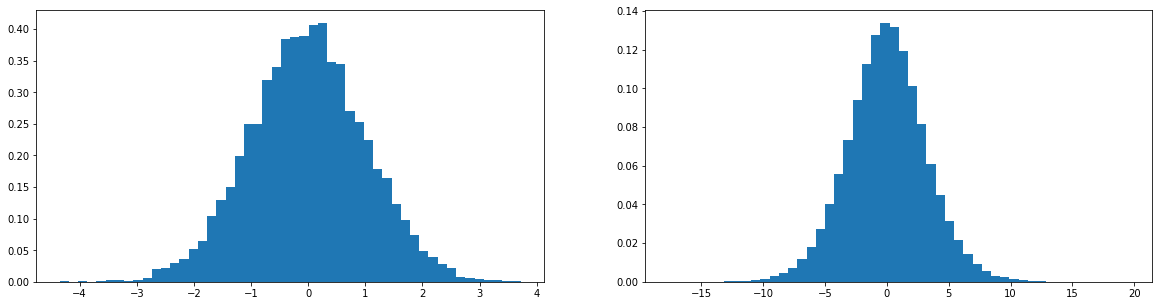

In [ ]:
# A more principled approach for initializing weights

x = torch.randn(1000,10)
w = torch.randn(10,200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(),50,density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(),50,density=True);

In [ ]:
  # here we test pushing a minibatch forward through the first layer
  #construct minibatch indices
  batch_size = 32
  with torch.no_grad():
    ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator=g) 
    Xb, Yb = Xtr[ix], Ytr[ix] #minibatch, (batch_size, block_size)

    # forward pass
    emb = C[Xb] #embeddings, # ##(batch_size, block_size, n_embd)
    embcat = emb.view(emb.shape[0],-1) # ##(batch_size, block_size*n_embd)
    hpreact = embcat @ W1 + b1 #h(idden layer)preact(ivations), ##(batch_size, n_hidden)
    h = torch.tanh(hpreact) # ##(batch_size, n_hidden)

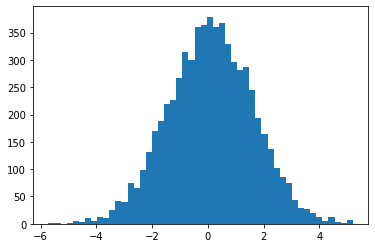

In [ ]:
plt.hist(hpreact.view(1,-1).tolist(),50); #hidden layer, preactivations

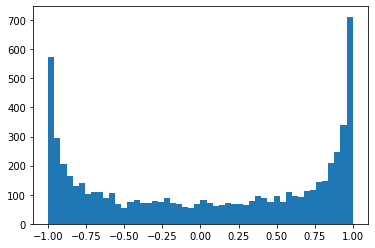

In [ ]:
plt.hist(h.view(1,-1).tolist(), 50); #activations

In [ ]:
# number of parameters
sum(p.nelement() for p in parameters)

11897

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
max_steps = 200000
batch_size = 32
out_freq = 10000
lossi = []

for i in range(max_steps):

  #construct minibatch indices
  ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator=g) 
  Xb, Yb = Xtr[ix], Ytr[ix] #batch

  # forward pass
  emb = C[Xb] #embedding characters (batch_size, )
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ W1 + b1 #h(idden layer)preact(ivations)
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, Yb)

  #backward pass
  for p in parameters:
    p.grad = None
  loss.backward() 

  #update
  lr = 0.1 if i < 100000 else 0.01 #schedule
  for p in parameters:
    p.data += -lr * p.grad

  #print
  if i % out_freq == 0:
    print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}') #prints the batch loss
  lossi.append(loss.log10().item())

      0 /  200000: 3.3068
  10000 /  200000: 1.8952
  20000 /  200000: 1.8887
  30000 /  200000: 1.9502
  40000 /  200000: 2.1633
  50000 /  200000: 2.0610
  60000 /  200000: 2.0746
  70000 /  200000: 2.4030
  80000 /  200000: 2.4077
  90000 /  200000: 2.2220
 100000 /  200000: 2.2720
 110000 /  200000: 1.8459
 120000 /  200000: 2.1808
 130000 /  200000: 1.9044
 140000 /  200000: 1.8374
 150000 /  200000: 2.3402
 160000 /  200000: 2.1982
 170000 /  200000: 1.6830
 180000 /  200000: 1.9442
 190000 /  200000: 2.0851


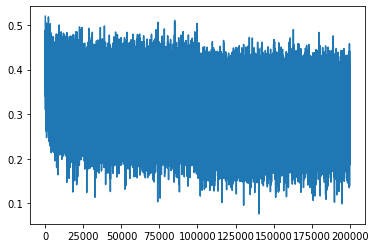

In [ ]:
plt.plot(lossi) #training loss

In [ ]:
# training loss
@torch.no_grad()
def split_loss(split):
  x,y = { 
      'train': (Xtr, Ytr),
      'val': (Xdev,Ydev),
      'test': (Xte,Yte),
  }[split]
  emb = C[x] #(N, block_size, n_embd)
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
  
split_loss('train')
split_loss('test')

train 2.0376079082489014
test 2.104883909225464


In [ ]:
#Sampling from the model (it is a distribution over word sequences after all)
g = torch.Generator().manual_seed(2147483647 + 11)

for _ in range(20):

  out = []
  context = [0] * block_size #starting context window ... (1,block_size)
  while True:
    emb=C[torch.tensor([context])] # (1, block_size, d)
    h = torch.tanh(emb.view(1,-1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits,dim=1) # get the output distribution on the characters
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:]+[ix] #shifts the context window to the right one character (now includes ix)
    out.append(ix)
    if ix == 0: #terminate at character '.'
      break
  print(''.join(i_to_s[i] for i in out))

naharlo.
ephaelam.
jace.
yaphanrodela.
vivaana.
sherana.
maddiel.
van.
kamaralyn.
jakhilah.
anoura.
lah.
jaiyah.
anne.
jana.
katalynn.
kyrsen.
arame.
sereian.
nis.


## Batch Normalization

Batch normalization is used to control the statistics of linear layers.
In the above code segments, we explored various ways of initializing the weights and saw how scaling these initializations was important so that the initial hidden layers' preactivations and activations do not saturate or extremize the nonlinearity. While clever initialization strategies are useful, a more robust method for training deep networks is Batch Normalization. 

Recall, we often model the training data as samples from some underlying distribution $x \sim P_{tr}$. In the forward mode, this distribution is processed layer-by-layer through the network, forming a sequence of pushforward distributions. In light of our previous discussion, we want the pushforward distributions of each preactivation (scalar, marginal distribution) to be roughly $\mathcal{N}(0,1)$. In this way, these pushforwards to not drift away and saturate the non-linearity.  

For non-gaussian distributions, which are occur more commonly in the network due to the nonlinearities, all we can perhaps ask is that the preactivations each have zero mean and unit variance.

For notational simplicity, let us consider just the activations of the $k$-th layer $h'$ given the activations of the previous layer $h$ are distributed according the the pushforward $P$ with mean $\mu_P$ and covariance matrix $\Sigma$:

$h' = f(z)$ where $z = W h + b$.

Here $z$ are the preactivations and $f$ is the nonlinearity that processes $z$ element-wise. Note, $h',z,h$ are all random variables and $W,b$ are trainable parameters of the model. 

Note that in general, we have that:

$\mathbb{E}[z] = W \mu_P + b$

$\textrm{Cov}[z] = W \Sigma W^\intercal$

As the nonlinearity $f$ processes each preactivation $z_i$ individually, we are only interested in the corresponding marginal distributions $p(z_i)$. Consider the $i-th$ preactivation $z_i$ and let $w_i = W_{i:}^\intercal$:

$\mu(z_i) = \mathbb{E}[z_i] = w_i^\intercal \mu_P + b_i$

$\sigma(z_i) = \textrm{Var}(z_i) = \sqrt{w_i^\intercal \Sigma_P w_i}$

Define $\mathcal{BN}(\cdot; \mu, \sigma)$ as follows:

$ \mathcal{BN}(z_i) = \frac{z_i - \mu(z_i)}{\sigma(z_i)}$.

Then, note that

$\mathbb{E}[\mathcal{BN}(z_i)] = 0 $

$\textrm{Var}(\mathcal{BN}(z_i)) = 1$

Forcing each preactivation to have the above property is a constraint on the model, which may cause worse performance. To allow additional flexibility, we include gain and bias parameters, which essentially lets the algorithm choose the best mean and variance (instead of $0$ and $1$ as above).

During implementations, we do not have access to the full training distribution. So, we use minibatches to approximate the statistics.

A note of caution -- a big challenge in using batch normalization layers is that it couples the examples in a minibatch, each example is not independently processed by the network during training. This can lead to problems. 


In [ ]:
#re-initialize all parameters using the Kaiming init method for tanh
n_embd = 10 #embedding dimension
n_hidden = 200
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd),             generator=g) #embedding matrix
W1 = torch.randn((n_embd * block_size,n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2 #scaling can be important, large weights that occur by chance (high dimensional gaussian) can cause the tanh nonlinearity to saturate, even at initialization. Saturated nonlinearities are flat, meaning the gradient of the loss wrt those parameters is zero. No learning for those parameters.
#b1 = torch.randn(n_hidden,                       generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),          generator=g) * 0.01 #scaling can help with unbalanced initial probabilities output by the softmax layer due to outliers in the random input layer
b2 = torch.randn(vocab_size,                     generator=g) * 0

bngain = torch.ones((1,n_hidden)) #batch normalization gain
bnbias = torch.ones((1,n_hidden)) #batch normalization bias
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1,n_hidden))


#parameters = [C, W1, b1, W2, b2, bngain, bnbias]
parameters = [C, W1, W2, b2, bngain, bnbias]

for p in parameters:
  p.requires_grad = True

In [ ]:
max_steps = 200000
batch_size = 32
out_freq = 10000
lossi = []

for i in range(max_steps):

  #construct minibatch indices
  ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator=g) 
  Xb, Yb = Xtr[ix], Ytr[ix] #batch

  # forward pass
  # recall C is (vocab_size,n_embd)
  emb = C[Xb] #embedding characters (batch_size, vocab_size, n_embed)
  embcat = emb.view(emb.shape[0],-1) #(batch_size, vocab_size * n_embed)
  # hpreact = embcat @ W1 + b1 #h(idden layer)preact(ivations), (batch_size, n_hidden)
  hpreact = embcat @ W1 #because batch normalization centers things, the bias b1 gets canceled out -- we don't need it.
  # We want to ensure that each entry of hpreact is roughly ~N(0,1)

#---------------------------------Begin BN Layer--------------------------------------------#
  bnmeani = hpreact.mean(0,keepdim=True)
  bnstdi = hpreact.std(0,keepdim=True)
  hpreact = bngain*(hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001*bnmeani #this is a little ad hoc...
    bnstd_running = 0.999 * bnstd_running + 0.001*bnstdi
#---------------------------------End BN Layer--------------------------------------------#
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, Yb)

  #backward pass
  for p in parameters:
    p.grad = None
  loss.backward() 

  #update
  lr = 0.1 if i < 100000 else 0.01 #schedule
  for p in parameters:
    p.data += -lr * p.grad

  #print
  if i % out_freq == 0:
    print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}') #prints the batch loss
  lossi.append(loss.log10().item())

      0 /  200000: 3.3056
  10000 /  200000: 1.9817
  20000 /  200000: 2.6418
  30000 /  200000: 2.0012
  40000 /  200000: 2.3115
  50000 /  200000: 1.8987
  60000 /  200000: 2.0529
  70000 /  200000: 2.3327
  80000 /  200000: 2.4092
  90000 /  200000: 2.2383
 100000 /  200000: 2.2589
 110000 /  200000: 2.2823
 120000 /  200000: 1.6926
 130000 /  200000: 1.9830
 140000 /  200000: 2.2002
 150000 /  200000: 2.0063
 160000 /  200000: 1.9524
 170000 /  200000: 2.4093
 180000 /  200000: 2.1574
 190000 /  200000: 2.2078


In [ ]:
# # calibrate the batch normalization at the end of training so that the forward pass does not require
# # a distribution / batch as an input. To do so, we use the mean and standard deviations of the full
# # training dataset rather than just batches of it. The relevant statistics from each batch may be viewed
# # as noisy estimates of the population statistics from the full training dataset. 

# # these quantities can be estimated recursively, which we have now chosen to implement above (hence commenting this section out).
# with torch.no_grad():
#   emb=C[Xtr]
#   embcat = emb.view(emb.shape[0],-1)
#   hpreact = embcat @W1 + b1
#   bnmean = hpreact.mean(0,keepdim=True)
#   bnstd = hpreact.std(0,keepdim=True)



In [ ]:
# training loss
@torch.no_grad()
def split_loss(split):
  x,y = { 
      'train': (Xtr, Ytr),
      'val': (Xdev,Ydev),
      'test': (Xte,Yte),
  }[split]
  emb = C[x] #(N, block_size, n_embd)
  embcat = emb.view(emb.shape[0],-1)
  hpreact = embcat @ W1 + b1
  hpreact = bngain* (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
  
split_loss('train')
split_loss('test')

train 2.066295862197876
test 2.1061031818389893


In [ ]:
#For batch normalization, the beneficial impact is observed more prominently in deep networks.

## Final Step : extending our above code to a more pytorch like implementation, with a deeper network.

This is not a one-to-one recreation of the pytorch methods and classes (check the documentation!), but it maintains a similar structure. Pay attention to dimensions of inputs and outputs. 

#First, without batch normalization (i.e., relying only on a "good" initialization).

In [ ]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self,x):
    self.out = x@self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight]+([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True 
    #parameters to be trained via backprop
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # running buffers
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self,x):
    #forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True)
      xvar = x.var(0, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x-xmean)/ torch.sqrt(xvar+self.eps)
    self.out = self.gamma * xhat +self.beta
    #buffer update
    if self.training:
      with torch.no_grad():
        # exponential moving averages
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  
  def __call__(self,x):
    self.out = torch.tanh(x)
    return self.out
  
  def parameters(self):
    return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), Tanh(),
    Linear(         n_hidden, vocab_size),
]

#initialization tricks
with torch.no_grad():
  # last layer: make less confident / more balanced
  layers[-1].weight *= 0.1
  # to the preceding layers: apply gain (kaiming init style)
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

46497


In [ ]:
# optimization (same as in previous sections)
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # constructing minibatch 
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb=C[Xb] #(batch_size, vocab_size, n_embed), embeds characters into vector space
  x = emb.view(emb.shape[0],-1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x,Yb)

  # backward pass
  for layer in layers:
    layer.out.retain_grad() #for debug purposes, AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i<100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}') #prints the batch loss
  lossi.append(loss.log10().item())
  
  with torch.no_grad():
    ud.append( [ (lr*p.grad.std() / p.data.std()).log10().item() for p in parameters ])
  if i > 1000:
    break # for debug to view initial activations, AFTER_DEBUG: remove

      0 /  200000: 3.2962


layer 1 (      Tanh): mean -0.07, std 0.76, saturated: 22.19%
layer 3 (      Tanh): mean +0.00, std 0.72, saturated: 12.16%
layer 5 (      Tanh): mean -0.00, std 0.75, saturated: 15.00%
layer 7 (      Tanh): mean -0.04, std 0.74, saturated: 13.25%
layer 9 (      Tanh): mean -0.01, std 0.71, saturated: 11.22%


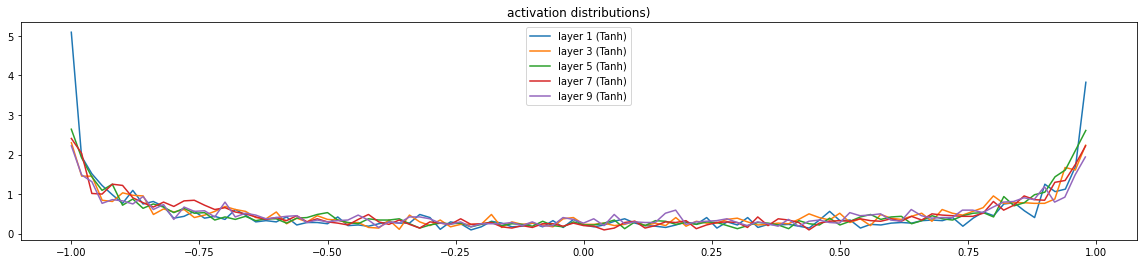

In [ ]:
#For debug, activation histograms
# The shape of these distributions is precisely because our initialized gain of 5/3
# The gain of 5/3 counteracts the squashing nature of the tanh nonlinearity
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers[:-1]): #not the output layer
  if isinstance(layer, Tanh): #activations = outputs of nonlinearity
    t = layer.out 
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distributions)')
plt.show()

layer 1 (      Tanh): mean -0.000005, std 3.06e-03
layer 3 (      Tanh): mean +0.000037, std 3.09e-03
layer 5 (      Tanh): mean -0.000007, std 2.89e-03
layer 7 (      Tanh): mean +0.000012, std 2.76e-03
layer 9 (      Tanh): mean +0.000007, std 2.34e-03


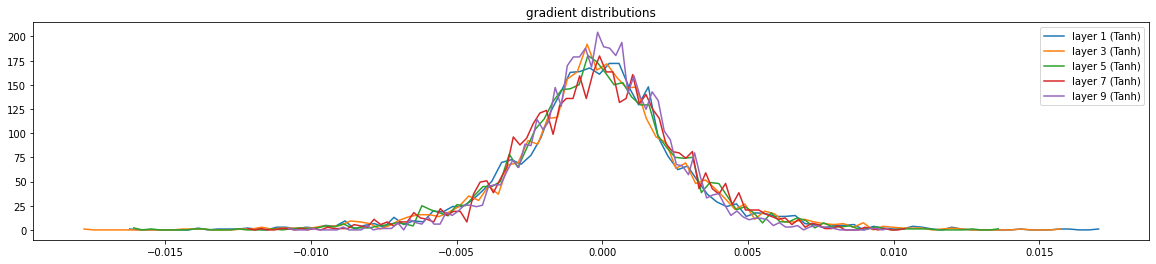

In [ ]:
#For debug, gradient histograms
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers[:-1]): #not the output layer
  if isinstance(layer, Tanh): #activations = outputs of nonlinearity
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %.2e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distributions')
plt.show()

weight   (27, 10) | mean +0.000772 | std 9.71e-03 | grad:data ratio 9.714506e-03
weight  (30, 100) | mean -0.000036 | std 8.73e-03 | grad:data ratio 2.792835e-02
weight (100, 100) | mean +0.000085 | std 7.42e-03 | grad:data ratio 4.417370e-02
weight (100, 100) | mean +0.000055 | std 6.24e-03 | grad:data ratio 3.681915e-02
weight (100, 100) | mean +0.000007 | std 6.16e-03 | grad:data ratio 3.650614e-02
weight (100, 100) | mean +0.000069 | std 5.22e-03 | grad:data ratio 3.102274e-02
weight  (100, 27) | mean +0.000000 | std 2.28e-02 | grad:data ratio 3.229574e-01


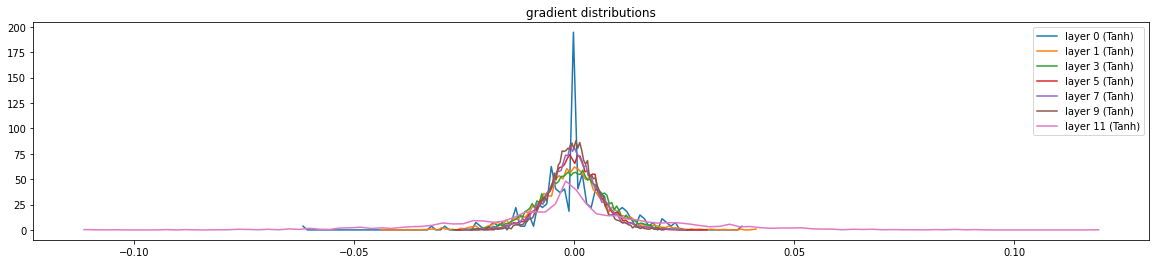

In [ ]:
#For debug, weight histograms
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters): #not the output layer
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %.2e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distributions')
plt.show()

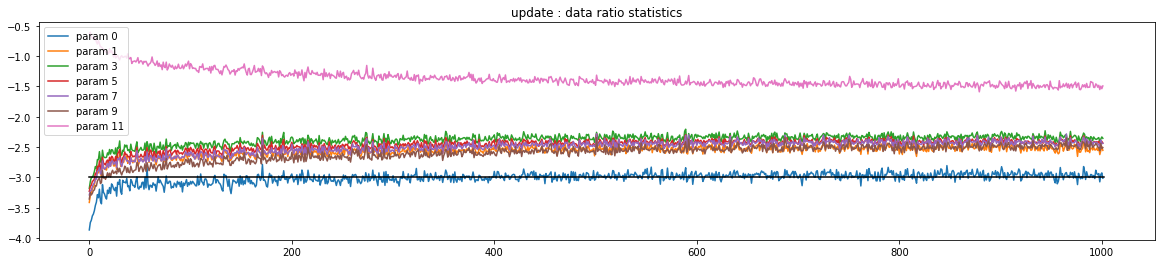

In [ ]:
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters): #not the output layer
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3,-3], 'k') # should be roughly 1e-3 or around -3 on our log10 plots, rule of thumb
plt.legend(legends)
plt.title('update : data ratio statistics')
plt.show()

In [ ]:
# training loss
@torch.no_grad()
def split_loss(split):
  x,y = { 
      'train': (Xtr, Ytr),
      'val': (Xdev,Ydev),
      'test': (Xte,Yte),
  }[split]
  emb=C[Xb] #(batch_size, vocab_size, n_embed), embeds characters into vector space
  c = emb.view(emb.shape[0],-1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
  
split_loss('train')
split_loss('test')

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 11)

for _ in range(20):

  out = []
  context = [0] * block_size #starting context window ... (1,block_size)
  while True:
    emb=C[Xb] #(batch_size, block_size, n_embed), embeds characters into vector space
    c = emb.view(emb.shape[0],-1)
    for layer in layers:
      x = layer(x)
    probs = F.softmax(x,dim=1) # get the output distribution on the characters
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:]+[ix] #shifts the context window to the right one character (now includes ix)
    out.append(ix)
    if ix == 0: #terminate at character '.'
      break
  print(''.join(i_to_s[i] for i in out))

# And now with batch normalization.

We can play around with the initial weights and find that Batch Normalization helps stabilize training -- particularly for deep networks -- and makes it more robust. 

In [92]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self,x):
    self.out = x@self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight]+([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True 
    #parameters to be trained via backprop
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # running buffers
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self,x):
    #forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True)
      xvar = x.var(0, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x-xmean)/ torch.sqrt(xvar+self.eps)
    self.out = self.gamma * xhat +self.beta
    #buffer update
    if self.training:
      with torch.no_grad():
        # exponential moving averages
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  
  def __call__(self,x):
    self.out = torch.tanh(x)
    return self.out
  
  def parameters(self):
    return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, vocab_size), BatchNorm1d(vocab_size), 
]

#initialization tricks
with torch.no_grad():
  # last layer: make less confident / more balanced
  # layers[-1].weight *= 0.1
  layers[-1].gamma *= 0.1
  # to the preceding layers: apply gain (kaiming init style)
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

47551


In [93]:
# optimization (same as in previous sections)
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # constructing minibatch 
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb=C[Xb] #(batch_size, block_size, n_embed), embeds characters into vector space
  x = emb.view(emb.shape[0],-1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x,Yb)

  # backward pass
  for layer in layers:
    layer.out.retain_grad() #for debug purposes, AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i<100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d} / {max_steps:7d}: {loss.item():.4f}') #prints the batch loss
  lossi.append(loss.log10().item())
  
  with torch.no_grad():
    ud.append( [ (lr*p.grad.std() / p.data.std()).log10().item() for p in parameters ])
  #if i > 1000:
    #break # for debug to view initial activations, AFTER_DEBUG: remove

      0 /  200000: 3.2870
  10000 /  200000: 2.3578
  20000 /  200000: 2.1042
  30000 /  200000: 1.9646
  40000 /  200000: 2.2145
  50000 /  200000: 2.2262
  60000 /  200000: 1.7340
  70000 /  200000: 2.1743
  80000 /  200000: 2.1895
  90000 /  200000: 1.8283
 100000 /  200000: 2.3646
 110000 /  200000: 2.2026
 120000 /  200000: 2.1039
 130000 /  200000: 1.8566
 140000 /  200000: 1.8049
 150000 /  200000: 1.9258
 160000 /  200000: 1.8757
 170000 /  200000: 1.8330
 180000 /  200000: 2.2324
 190000 /  200000: 2.0522


layer 2 (      Tanh): mean -0.01, std 0.69, saturated: 14.06%
layer 5 (      Tanh): mean -0.02, std 0.72, saturated: 16.84%
layer 8 (      Tanh): mean -0.00, std 0.75, saturated: 15.81%
layer 11 (      Tanh): mean +0.02, std 0.77, saturated: 16.75%
layer 14 (      Tanh): mean -0.02, std 0.79, saturated: 18.91%


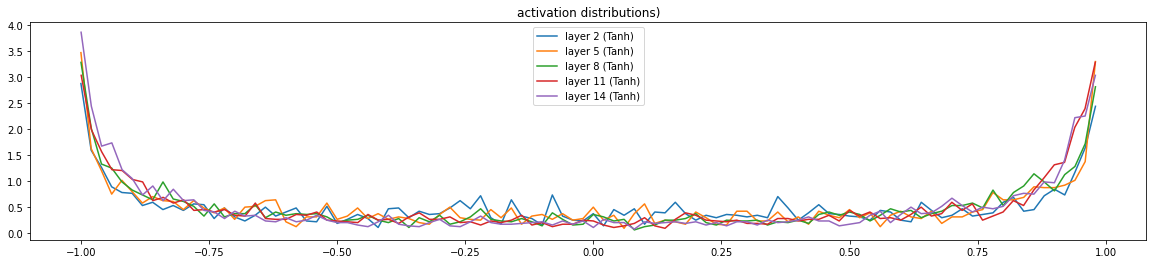

In [97]:
#For debug, activation histograms
# The shape of these distributions is precisely because our initialized gain of 5/3
# The gain of 5/3 counteracts the squashing nature of the tanh nonlinearity
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers[:-1]): #not the output layer
  if isinstance(layer, Tanh): #activations = outputs of nonlinearity
    t = layer.out 
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distributions)')
plt.show()

layer 2 (      Tanh): mean -0.000000, std 3.42e-03
layer 5 (      Tanh): mean -0.000000, std 3.29e-03
layer 8 (      Tanh): mean -0.000000, std 3.27e-03
layer 11 (      Tanh): mean -0.000000, std 3.54e-03
layer 14 (      Tanh): mean -0.000000, std 3.85e-03


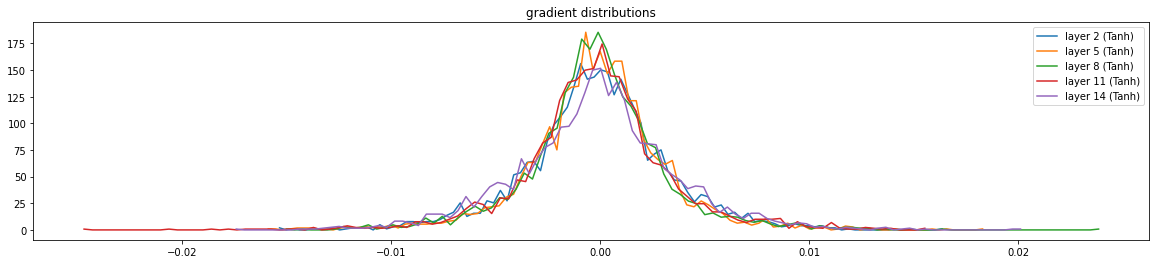

In [98]:
#For debug, gradient histograms
plt.figure(figsize=(20,4))
legends = []
for i,layer in enumerate(layers[:-1]): #not the output layer
  if isinstance(layer, Tanh): #activations = outputs of nonlinearity
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %.2e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distributions')
plt.show()

weight   (27, 10) | mean +0.000000 | std 1.50e-02 | grad:data ratio 1.370268e-02
weight  (30, 100) | mean +0.000084 | std 7.88e-03 | grad:data ratio 1.922244e-02
weight (100, 100) | mean +0.000060 | std 5.06e-03 | grad:data ratio 2.049041e-02
weight (100, 100) | mean -0.000087 | std 5.18e-03 | grad:data ratio 2.133905e-02
weight (100, 100) | mean +0.000043 | std 5.20e-03 | grad:data ratio 2.196100e-02
weight (100, 100) | mean -0.000013 | std 5.24e-03 | grad:data ratio 2.278768e-02
weight  (100, 27) | mean +0.000054 | std 9.17e-03 | grad:data ratio 2.777520e-02


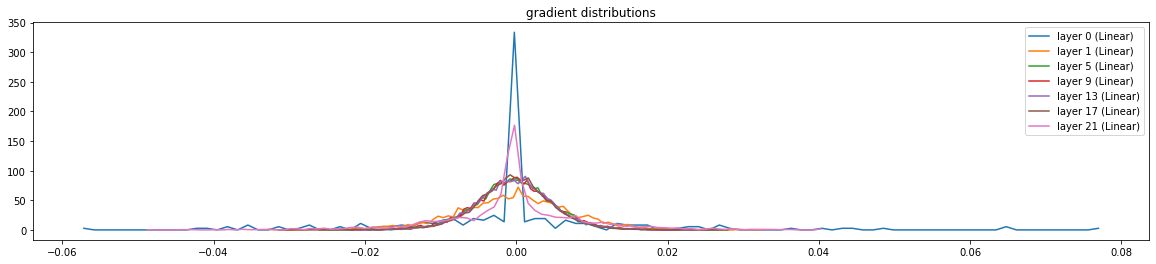

In [99]:
#For debug, weight histograms
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters): #not the output layer
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %.2e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distributions')
plt.show()

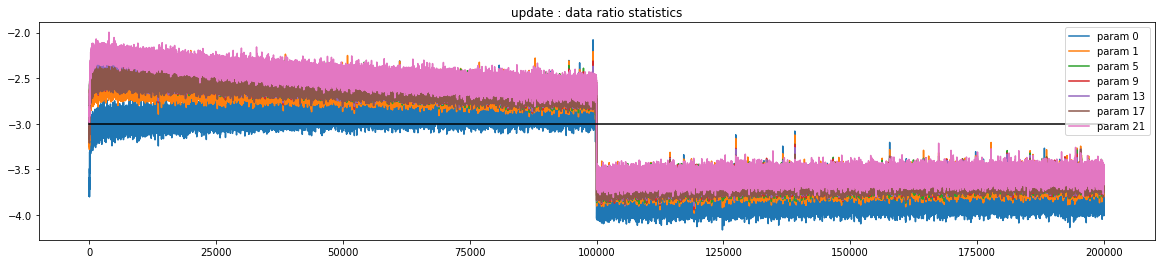

In [100]:
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters): #not the output layer
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3,-3], 'k') # should be roughly 1e-3 or around -3 on our log10 plots, rule of thumb
plt.legend(legends)
plt.title('update : data ratio statistics')
plt.show()

#the jump we see below is because we learning rate / step size scheduler decreases the learning rate after 100000 iterations

In [101]:
#first we have to put the network in evaluation mode
for layer in layers:
    if isinstance(layer, BatchNorm1d):
      layer.training = False

In [102]:
# training loss
@torch.no_grad()
def split_loss(split):
  x,y = { 
      'train': (Xtr, Ytr),
      'val': (Xdev,Ydev),
      'test': (Xte,Yte),
  }[split]
  emb=C[x] #(batch_size, vocab_size, n_embed), embeds characters into vector space
  z = emb.view(emb.shape[0],-1)
  for layer in layers:
    z = layer(z)
  loss = F.cross_entropy(z, y)
  print(split, loss.item())
  
split_loss('train')
split_loss('test')

train 2.012324094772339
test 2.084648847579956


In [103]:
g = torch.Generator().manual_seed(2147483647 + 11)

for _ in range(20):
  out = []
  context = [0] * block_size #starting context window ... (1,block_size)
  while True:
    emb=C[torch.tensor([context])] #(batch_size, block_size, n_embed), embeds characters into vector space
    z = emb.view(emb.shape[0],-1)
    for layer in layers:
      z = layer(z)
    probs = F.softmax(z,dim=1) # get the output distribution on the characters
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:]+[ix] #shifts the context window to the right one character (now includes ix)
    out.append(ix)
    if ix == 0: #terminate at character '.'
      break
  print(''.join(i_to_s[i] for i in out))

naharlo.
ephaan.
martyn.
yarosaradlyn.
vivaan.
ree.
hana.
maddiel.
vin.
kamaralyn.
jakhilahna.
oman.
lah.
jaiyah.
niver.
ana.
katalibah.
yoselya.
ame.
sere.
